In [ ]:
# Install required packages
!pip install scikit-plot -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Create realistic credit data
np.random.seed(42)
n_samples = 5000

data = pd.DataFrame({
    'age': np.clip(np.random.normal(45, 15, n_samples), 18, 80).astype(int),
    'income': np.clip(np.random.lognormal(10.5, 0.6, n_samples), 20000, 150000),
    'debt_ratio': np.random.beta(2, 5, n_samples) * 100,
    'payment_history': np.random.beta(8, 2, n_samples) * 100,
    'credit_utilization': np.random.beta(3, 4, n_samples) * 100,
    'credit_history': np.clip(np.random.exponential(10, n_samples), 0, 40)
})

# Create target variable based on business rules
credit_score = (
    0.3 * (data['income'] / 10000) +
    0.4 * (data['payment_history'] / 100) +
    0.2 * (100 - data['debt_ratio']) / 100 +
    0.1 * (40 - data['credit_history']) / 40 +
    np.random.normal(0, 0.3, n_samples)
)

data['credit_worthy'] = (credit_score > np.median(credit_score)).astype(int)

print(f"Dataset shape: {data.shape}")
print(f"\nCredit Worthiness Distribution:")
print(data['credit_worthy'].value_counts())
print(f"\nBad Credit Rate: {(1 - data['credit_worthy'].mean()):.1%}")
data.head()

Dataset shape: (5000, 7)

Credit Worthiness Distribution:
credit_worthy
0    2500
1    2500
Name: count, dtype: int64

Bad Credit Rate: 50.0%


,age,income,debt_ratio,payment_history,credit_utilization,credit_history,credit_worthy
0,52,28162.432580,18.807715,66.259466,40.867622,8.672833,0
1,42,27665.779601,17.038905,83.586240,29.720572,0.258791,0
2,54,20000.000000,51.137942,95.308276,43.055635,35.776446,0
3,67,29790.531437,31.879261,71.822487,41.405381,2.403785,0
4,41,56370.285685,38.443918,80.039591,64.949511,8.858518,1


DATA ANALYSIS


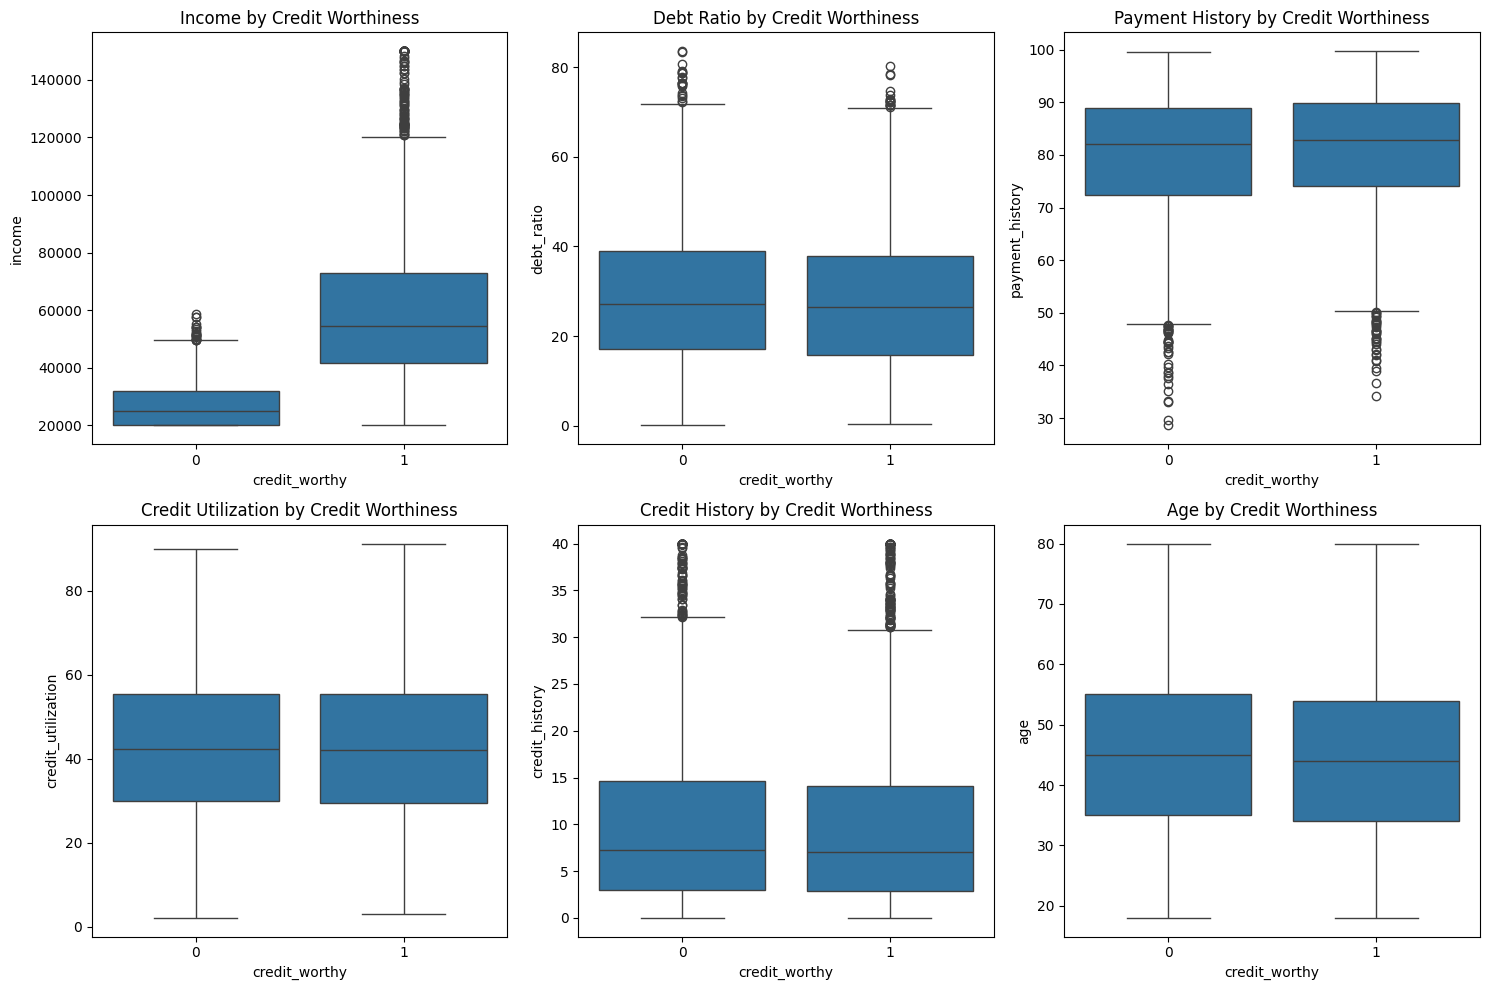

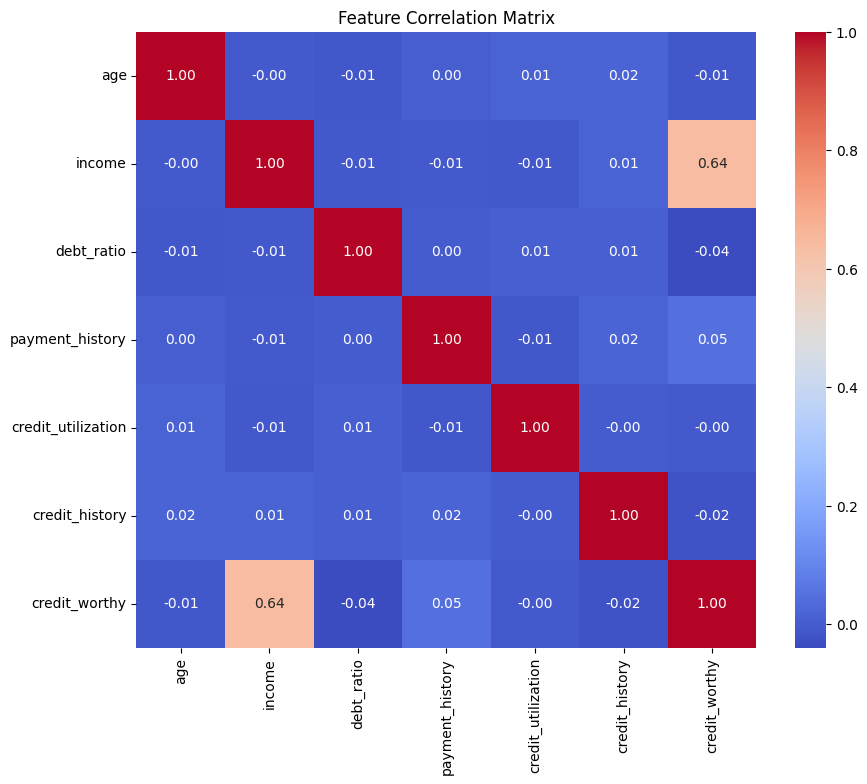

In [ ]:
print("DATA ANALYSIS")

# Check feature distributions by credit worthiness
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

features = ['income', 'debt_ratio', 'payment_history', 'credit_utilization', 'credit_history', 'age']
titles = ['Income', 'Debt Ratio', 'Payment History', 'Credit Utilization', 'Credit History', 'Age']

for i, (feature, title) in enumerate(zip(features, titles)):
    row, col = i // 3, i % 3
    sns.boxplot(x='credit_worthy', y=feature, data=data, ax=axes[row, col])
    axes[row, col].set_title(f'{title} by Credit Worthiness')

plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

In [ ]:
# Create new features
data['income_to_debt'] = data['income'] / (data['debt_ratio'] + 1)
data['payment_performance'] = data['payment_history'] / (data['credit_utilization'] + 1)

# Select final features
X = data[['income', 'debt_ratio', 'payment_history', 'credit_utilization',
          'credit_history', 'income_to_debt', 'payment_performance']]
y = data['credit_worthy']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Features: {list(X.columns)}")

Training set: (4000, 7)
Test set: (1000, 7)
Features: ['income', 'debt_ratio', 'payment_history', 'credit_utilization', 'credit_history', 'income_to_debt', 'payment_performance']


In [ ]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Train and evaluate
results = {}
for name, model in models.items():
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_proba = model.predict_proba(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)

    accuracy = (y_pred == y_test).mean()
    auc_score = roc_auc_score(y_test, y_proba[:, 1])

    results[name] = {'Accuracy': accuracy, 'ROC-AUC': auc_score}
    print(f" {name} trained - Accuracy: {accuracy:.3f}, AUC: {auc_score:.3f}")

# Compare results
results_df = pd.DataFrame(results).T
print("\n MODEL COMPARISON:")
display(results_df.round(3))

 Logistic Regression trained - Accuracy: 0.871, AUC: 0.944
 Decision Tree trained - Accuracy: 0.793, AUC: 0.793
 Random Forest trained - Accuracy: 0.855, AUC: 0.934

 MODEL COMPARISON:


,Accuracy,ROC-AUC
Logistic Regression,0.871,0.944
Decision Tree,0.793,0.793
Random Forest,0.855,0.934


BEST MODEL: Logistic Regression

 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Bad Credit       0.85      0.89      0.87       500
 Good Credit       0.89      0.85      0.87       500

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



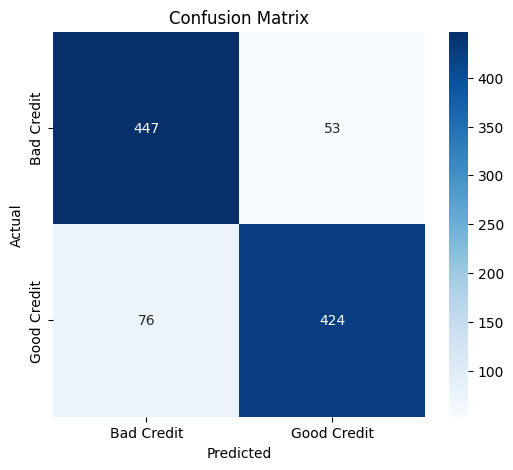

In [ ]:
# Select best model
best_model_name = max(results, key=lambda x: results[x]['ROC-AUC'])
print(f"BEST MODEL: {best_model_name}")

if best_model_name == 'Logistic Regression':
    best_model = models['Logistic Regression']
    y_pred = best_model.predict(X_test_scaled)
else:
    best_model = models[best_model_name]
    y_pred = best_model.predict(X_test)

# Detailed evaluation
print("\n CLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred, target_names=['Bad Credit', 'Good Credit']))

# Confusion Matrix
plt.figure(figsize=(6, 5))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bad Credit', 'Good Credit'],
            yticklabels=['Bad Credit', 'Good Credit'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# Feature importance
if best_model_name != 'Logistic Regression':
    importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance, x='importance', y='feature')
    plt.title('Feature Importance for Credit Scoring')
    plt.show()

    print("KEY CREDIT FACTORS:")
    for i, row in importance.head(3).iterrows():
        print(f"  {row['feature']}: {row['importance']:.3f}")

# Business metrics
from sklearn.metrics import precision_score, recall_score

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"\n BUSINESS IMPACT:")
print(f"• Precision: {precision:.1%} - Of approved applicants, {precision:.1%} are actually creditworthy")
print(f"• Recall: {recall:.1%} - We identify {recall:.1%} of all creditworthy applicants")
print(f"• Default Prevention: Model helps avoid bad loans while maintaining approvals")


 BUSINESS IMPACT:
• Precision: 88.9% - Of approved applicants, 88.9% are actually creditworthy
• Recall: 84.8% - We identify 84.8% of all creditworthy applicants
• Default Prevention: Model helps avoid bad loans while maintaining approvals


In [ ]:
# Simulate new credit applications
new_applicants = pd.DataFrame({
    'income': [45000, 75000, 30000],
    'debt_ratio': [35, 65, 25],
    'payment_history': [85, 45, 95],
    'credit_utilization': [30, 80, 20],
    'credit_history': [5, 15, 2],
    'income_to_debt': [45000/36, 75000/66, 30000/26],
    'payment_performance': [85/31, 45/81, 95/21]
})

print("NEW CREDIT APPLICATIONS:")
display(new_applicants)

# Make predictions
if best_model_name == 'Logistic Regression':
    new_applicants_scaled = scaler.transform(new_applicants)
    predictions = best_model.predict(new_applicants_scaled)
    probabilities = best_model.predict_proba(new_applicants_scaled)
else:
    predictions = best_model.predict(new_applicants)
    probabilities = best_model.predict_proba(new_applicants)

print("\n PREDICTION RESULTS:")
for i, (pred, prob) in enumerate(zip(predictions, probabilities)):
    decision = "APPROVE " if pred == 1 else "REJECT "
    risk_level = "Low" if prob[1] > 0.7 else "Medium" if prob[1] > 0.4 else "High"
    print(f"Applicant {i+1}: {decision} | Risk: {risk_level} | Good Credit Probability: {prob[1]:.1%}")

NEW CREDIT APPLICATIONS:


,income,debt_ratio,payment_history,credit_utilization,credit_history,income_to_debt,payment_performance
0,45000,35,85,30,5,1250.000000,2.741935
1,75000,65,45,80,15,1136.363636,0.555556
2,30000,25,95,20,2,1153.846154,4.523810



 PREDICTION RESULTS:
Applicant 1: APPROVE  | Risk: Low | Good Credit Probability: 80.9%
Applicant 2: APPROVE  | Risk: Low | Good Credit Probability: 99.2%
Applicant 3: REJECT  | Risk: High | Good Credit Probability: 31.8%
